In [171]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
import numpy as np

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [172]:
data = pd.read_csv('train_data/field_4.csv')

In [173]:
data.head()

,timestamp,Soil humidity 4
0,2019-02-23 00:00:00,26.57
1,2019-02-23 00:05:00,26.58
2,2019-02-23 00:10:00,26.59
3,2019-02-23 00:15:00,26.61
4,2019-02-23 00:20:00,26.62


In [174]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [5]:
data['hour'] = data['timestamp'].dt.hour
data['month'] = data['timestamp'].dt.month
data['year'] = data['timestamp'].dt.year
data['minute'] = data['timestamp'].dt.minute

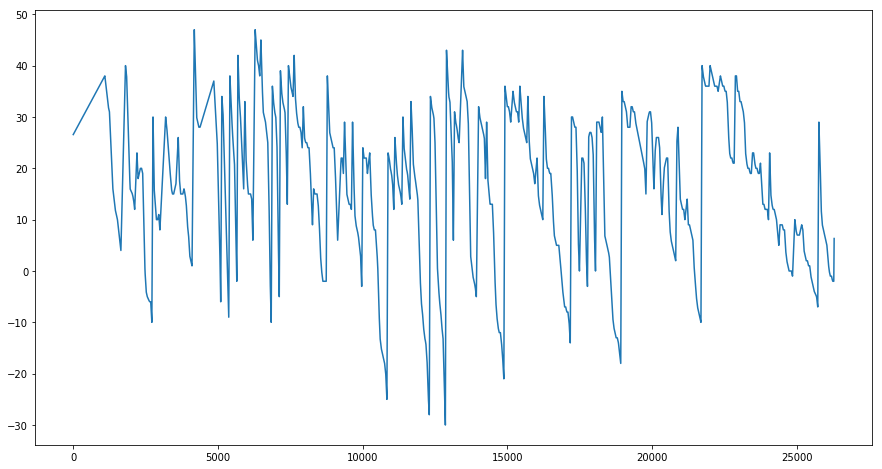

In [94]:
plt.figure(figsize=(15,8))
data['Soil humidity 4'].plot()

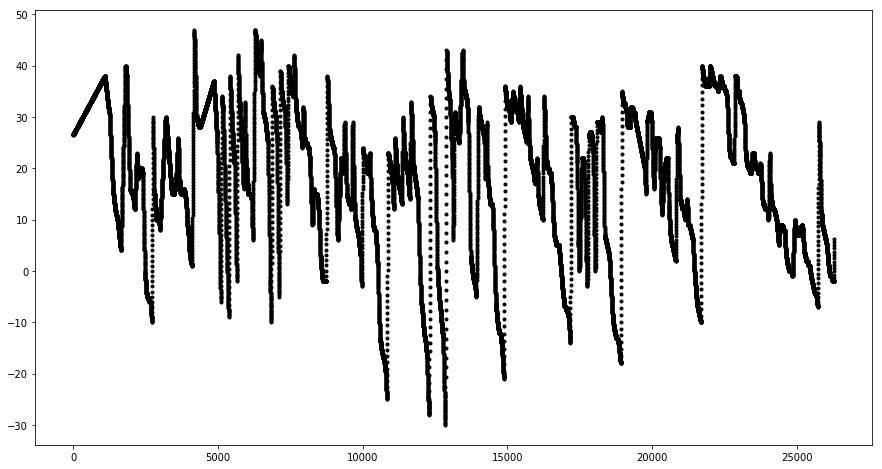

In [95]:
plt.figure(figsize=(15,8))
data['Soil humidity 4'].plot(style = 'k.')

C:\Users\mxcsy\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


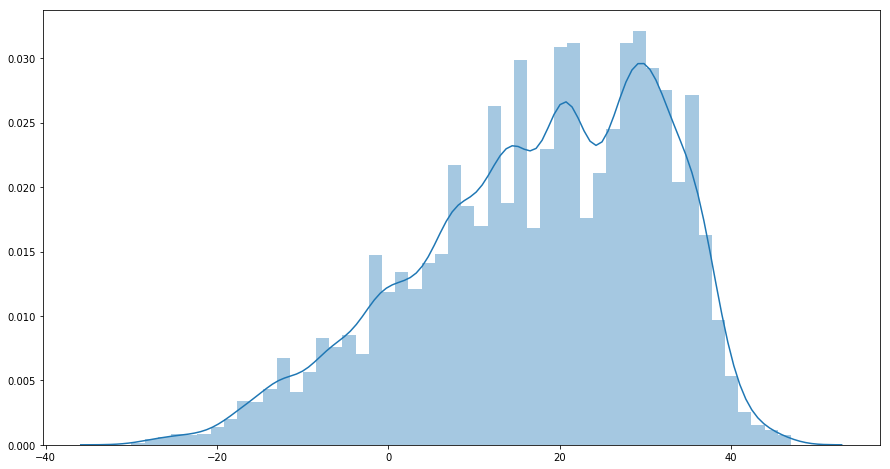

In [96]:
plt.figure(figsize=(15,8))
sns.distplot(data['Soil humidity 4'].values)

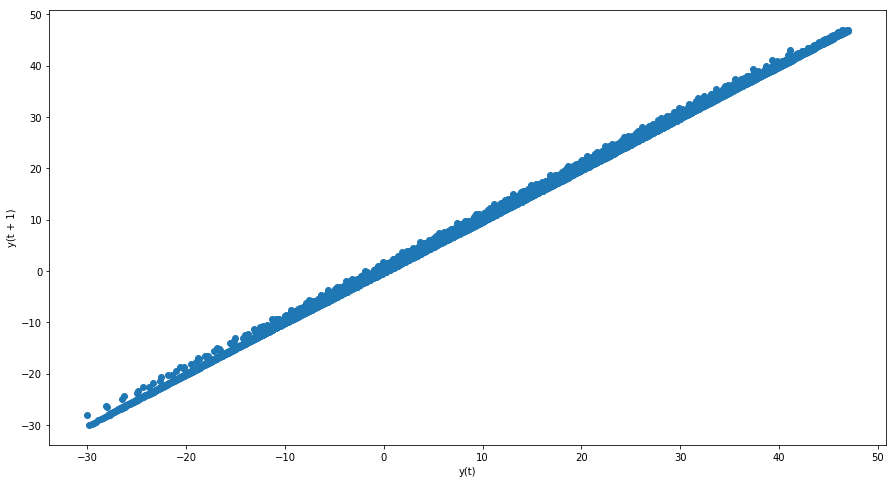

In [97]:
from pandas.plotting import lag_plot 
plt.figure(figsize=(15,8))
lag_plot(data['Soil humidity 4'], lag=1) 

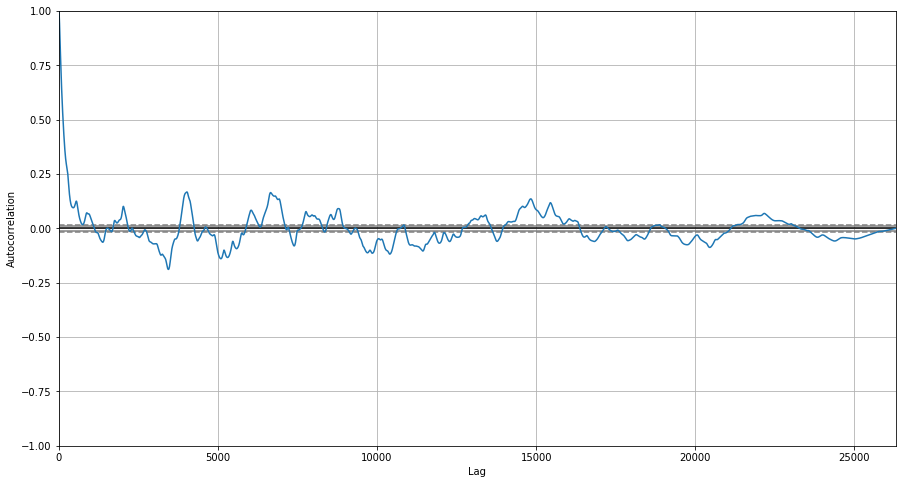

In [98]:
from pandas.plotting import autocorrelation_plot 
plt.figure(figsize=(15,8))
autocorrelation_plot(data['Soil humidity 4']) 

In [99]:
print(data.describe())

       Soil humidity 4
count     26301.000000
mean         17.511572
std          14.248260
min         -30.000000
25%           8.000000
50%          19.600000
75%          29.050000
max          47.000000


In [158]:
data.set_index('timestamp', inplace = True)

In [101]:
resample = data.resample('12H')
hourly_mean_sales = resample.mean() 
hourly_mean_sales.to_csv('field_4_12_hour.csv')
resample = data.resample('H')
hourly_mean_sales = resample.mean() 
hourly_mean_sales.to_csv('field_4_hour.csv')
resample = data.resample('D')
daily_mean_sales = resample.mean() 
daily_mean_sales.to_csv('field_4_day.csv')

In [60]:
hourly_mean_sales.to_csv('field_1_12_hour.csv')

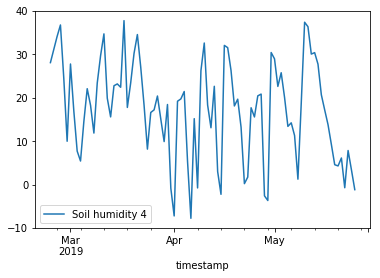

In [107]:
daily_mean_sales.plot()

In [149]:
daily_mean_sales.shape

(92, 1)

In [163]:
data = data.values
train, test = data[:18000,], data[18000:]

In [164]:
from statsmodels.tsa.arima_model import ARIMA
arima = ARIMA(train,[3,1,1])
result = arima.fit(disp=False)

In [168]:
pred = result.predict(1, len(test), typ='levels')

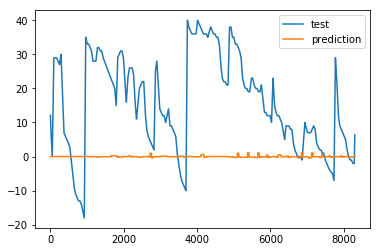

In [169]:
plt.plot(test, label= 'test')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()

In [170]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(pred, test)
print(np.sqrt(mse))

21.09151249839422


In [176]:
train, test = data.iloc[:18000,:] ,data.iloc[18000:,:] 

In [177]:
train.columns = ['ds' , 'y']
test.columns = ['ds' , 'y']

In [179]:
model = Prophet()
model.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
C:\Users\mxcsy\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [180]:
forcast = model.predict(test)

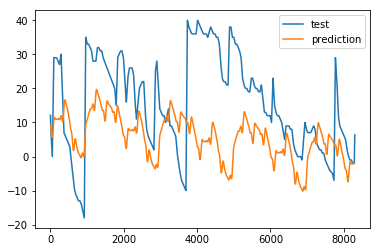

In [190]:
plt.plot(test['y'].values, label= 'test')
plt.plot(forcast['yhat'].values, label = 'prediction')
plt.legend()
plt.show()

In [191]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(forcast['yhat'].values, test['y'].values)
print(np.sqrt(mse))

17.06359891392676


In [194]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data['Soil humidity 4'], model='additive', freq=12)

<Figure size 432x288 with 0 Axes>

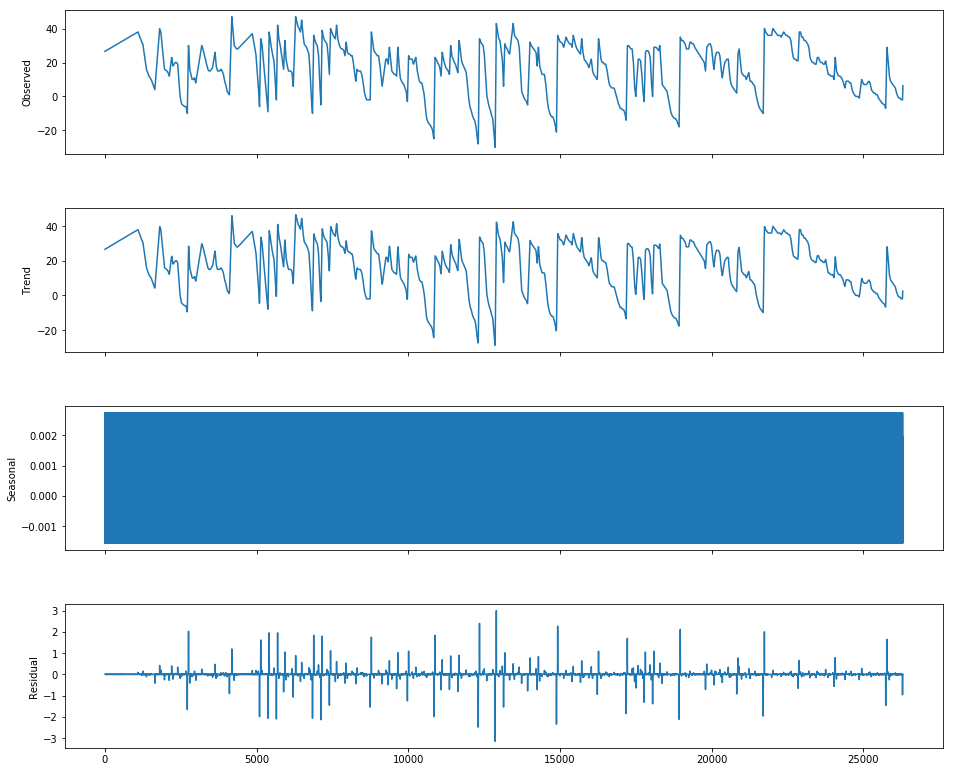

In [195]:
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

In [196]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

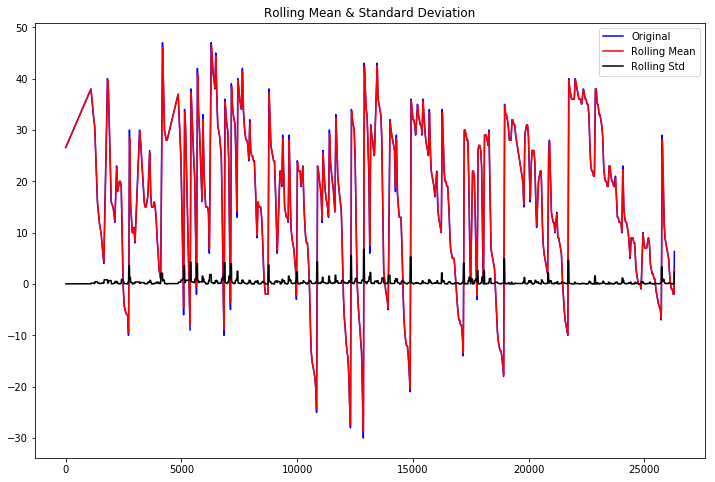

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -8.866203e+00
p-value                        1.438209e-14
#Lags Used                     2.000000e+01
Number of Observations Used    2.628000e+04
Critical Value (1%)           -3.430599e+00
Critical Value (5%)           -2.861650e+00
Critical Value (10%)          -2.566829e+00
dtype: float64


In [197]:
test_stationarity(data['Soil humidity 4'])


C:\Users\mxcsy\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


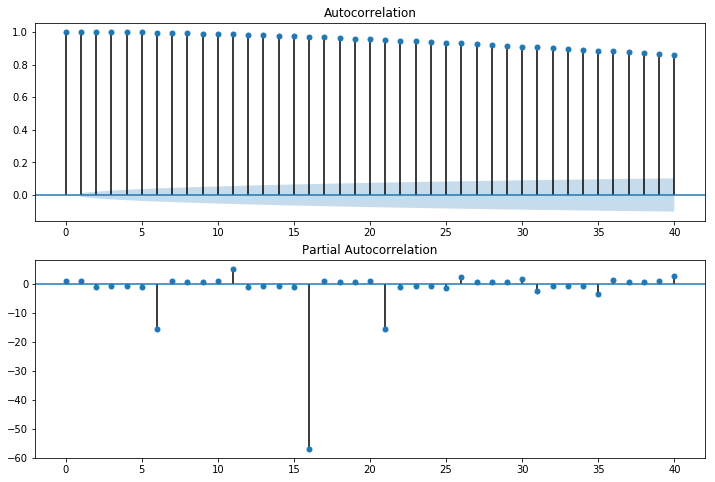

In [198]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data['Soil humidity 4'], lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data['Soil humidity 4'], lags=40, ax=ax2)# , lags=40